In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
%matplotlib notebook

In [56]:
def relaxation_method(f, xo, num_it):
    rollout = [xo]
    for i in range(num_it):
        x = f(xo)
        rollout.append(x)
        xo = x
    return np.array(rollout)

def error_estimate(xo, x, df):
    return (xo - x)/(1 - 1/max(df(xo), int(1E-14)))

def error_estimate2(x0, x1, x2):
    return (x1 - x2)**2/(2*x1 - x0 - x2)

### Analysis of Convergence of Relaxation Method

<IPython.core.display.Javascript object>


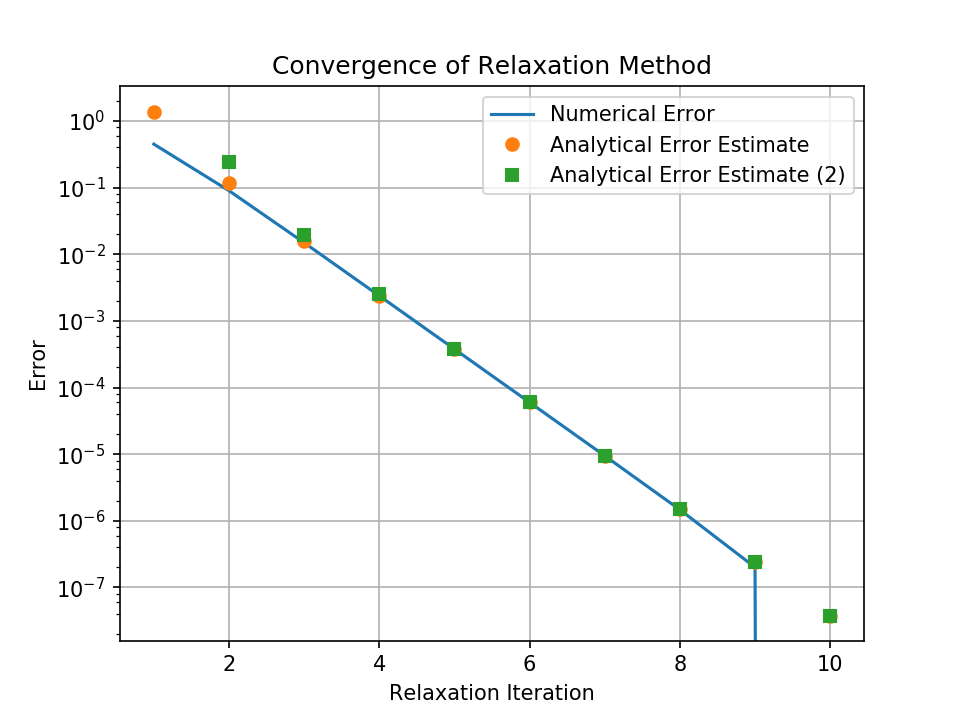

In [61]:
def f(x): return 2 - np.exp(-x)
def df(x): return np.exp(-x)
y = relaxation_method(f, .5, 10)
dy = np.array([error_estimate(*y[i:i+2], df) for i in range(0, len(y)-1)])
dy2 = np.array([error_estimate2(*y[i:i+3]) for i in range(0, len(y)-2)])
fig, ax = plt.subplots()
ax.plot(range(1, 11), np.abs(y[1:] - y[-1]), label="Numerical Error")
ax.plot(range(1, 11), np.abs(dy), label="Analytical Error Estimate", marker="o", ls='')
ax.plot(range(2, 11), np.abs(dy2), label="Analytical Error Estimate (2)", marker="s", ls='')
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("Relaxation Iteration")
ax.set_ylabel("Error")
ax.set_title("Convergence of Relaxation Method")

### Ferromagnetism

In the mean-field theory of ferromagnetism, the strength $M$ of magnetization of a ferromagnetic material depends on temperature according to the fixed-point equation:

\begin{equation}
M = \mu \tanh{\frac{JM}{k_{B}T}}
\end{equation}

or

\begin{equation}
m = \tanh{\frac{Cm}{T}}
\end{equation}

where $C=\mu J/k_{B}$.

The error associated with relaxation method estimate, $m'$, given the prior estimate $m$ is: 

\begin{equation}
\epsilon' = \frac{m - m'}{1 - T\cosh{m/T}}
\end{equation}

Where $C$ was set to 1.

Let's plot estimates for $m(T)$ with an accuracy of $10^{-6}$

In [83]:
@numba.njit
def mag(T, mo): return np.tanh(mo/T) if T > 0. else 1.

@numba.njit
def error_m(mo, m, T): return (mo - m)/(1. - T*np.cosh(mo/T)) if T > 0. else 0.

@numba.njit
def est_m(T, err_bnd=1., mo=1., it_lim=int(1E6)):
    """ Return m(T) accurate within the specified error bound."""
    cnt = 0
    m = mag(T, mo)  
    error = error_m(mo, m, T)
    while np.abs(error) > err_bnd:
        mo = m
        m = mag(T, mo)  
        error = error_m(mo, m, T)
        cnt += 1
        if cnt > it_lim:
            return -1
    return m

<IPython.core.display.Javascript object>


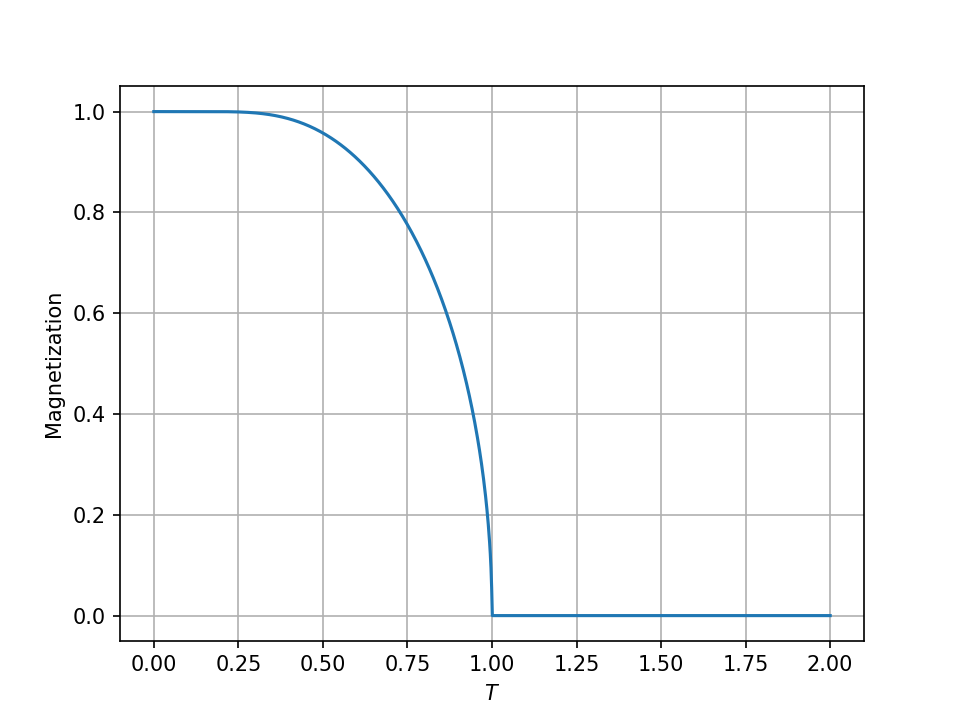

In [87]:
T_domain = np.linspace(0, 2, 1000)
m_T = np.array([est_m(T, 1e-6) for T in T_domain])

fig, ax = plt.subplots()
ax.plot(T_domain, m_T)
ax.grid()
ax.set_ylabel("Magnetization")
ax.set_xlabel(r"$T$")